In [1]:
import Dans_Diffraction as dif
import Dans_Diffraction.functions_scattering as fs
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import csv
from tqdm import tqdm
import xarray as xr
from zipfile import ZipFile, ZIP_DEFLATED

In [20]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal

In [2]:
cif_list = ['NaCl_cubic', 'BaSO4_orthorhombic']
cif_files_lst = [f'cif_files/{f}.cif' for f in cif_list]

crystals = [dif.Crystal(cif_file) for cif_file in cif_files_lst]
multi_xtl = dif.MultiCrystal(crystals)

In [3]:
# Set up scattering parameters
energy_kev = 12.398 / 0.1665
min_twotheta = 1
max_twotheta = 10
scattering_type = 'xray'
num_patterns = 20

In [4]:
# Set up scatter
multi_xtl.setup_scatter(
    scattering_type=scattering_type, 
    powder_units='twotheta', 
    energy_kev=energy_kev,
    min_twotheta=min_twotheta,
    max_twotheta=max_twotheta,
    output=False,
    powder_lorentz=1
)

In [5]:
# Vary lattice parameters
all_lps = np.linspace(crystals[0].Cell.lp(), crystals[0].Cell.lp()*np.array([2,2,2,1,1,1]), num_patterns)

In [6]:
# Make lists to hold data
tths = []
intensities = []
all_reflections = []

In [7]:
# Iter thru patterns for all crystals

for i in tqdm(range(num_patterns), desc="Simulating multiphase patterns"):
    # Set lattice for each crystal
    for xtl in multi_xtl.crystal_list:
        xtl.Cell.latt(all_lps[i])

    # Initialize arrays for summing
    combined_intensity = None
    combined_tth = None
    combined_refl = []

    for xtl in multi_xtl.crystal_list:
        tth, inten, refl = xtl.Scatter.powder(return_hkl=True)

        if combined_intensity is None:
            combined_tth = tth
            combined_intensity = inten
        else:
            combined_intensity += inten  # sum intensities across phases

        combined_refl.extend(refl)

    tths.append(combined_tth)
    intensities.append(combined_intensity)
    all_reflections.append(combined_refl)


Simulating multiphase patterns: 100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


In [8]:
# Turn lists to arrays
tths = np.array(tths)
intensities = np.array(intensities)

In [9]:
# Prepare binary arrays for indexing peaks
binary_peaks = []
tol = 0.1
for i in range(num_patterns):
    peaks = np.zeros_like(tths[i], dtype=int)
    for ref in all_reflections[i]:
        tth_val = ref[3]
        idx = np.argmin(np.abs(tths[i] - tth_val))
        if np.abs(tths[i][idx] - tth_val) < tol:
            peaks[idx-5:idx+8] = 1
    binary_peaks.append(peaks)

binary_peaks = np.array(binary_peaks)

In [21]:
noisy_intensities = add_noise_by_percentage(intensities, 0.05)

In [23]:
ds = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_intensities),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords={
        "pattern": np.arange(num_patterns),
        "x": np.linspace(min_twotheta, max_twotheta, noisy_intensities.shape[1])
    },
    attrs={
        "CIFs": cif_list,
        "description": "Multiphase powder diffraction simulated with MultiCrystal",
        "energy_kev": energy_kev
    }
)

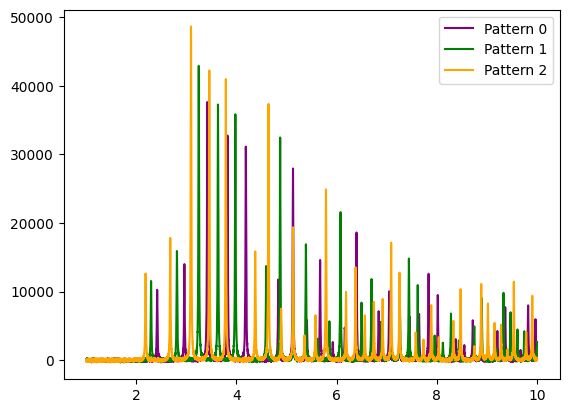

In [24]:
plt.figure()
intens = ds["Intensities"].values
bins = ds["BinaryArr"].values
x = ds["x"].values

colors = ['purple', 'green', 'orange']

for i in range(3):
    plt.plot(x, intens[i], color=colors[i], label=f'Pattern {i}')

plt.legend()
plt.show()

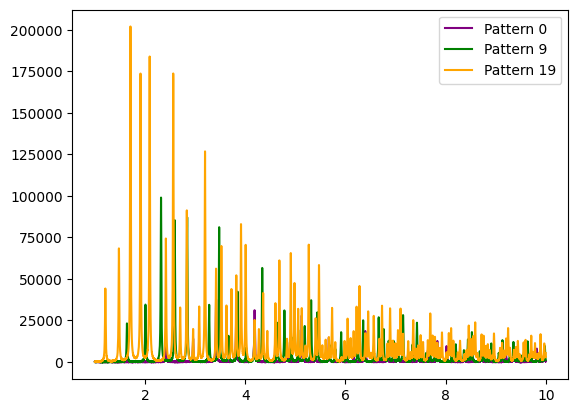

In [25]:
plt.figure()

plt.plot(x, intens[0], color='purple', label='Pattern 0')
plt.plot(x, intens[9], color='green', label='Pattern 9')
plt.plot(x, intens[19], color='orange', label='Pattern 19')

plt.legend()
plt.show()

BELOW AND ABOVE ARE DIFFERENT!

In [1]:
# Import relevant libraries

import Dans_Diffraction as dif
import Dans_Diffraction.functions_scattering as fs
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

In [2]:
# all crystals that will be in multi-phase pattern
all_crystals = ['BaSO4_orthorhombic', 'NaCl_cubic']
cif_files = [f'cif_files/{i}.cif' for i in all_crystals]

# Create crystal objects for the crystals, put in list
xtls = [dif.Crystal(i) for i in cif_files]

multi_xtl = dif.MultiCrystal(xtls)

In [3]:
multi_xtl

MultiCrystal([BaSO4_orthorhombic, NaCl_cubic])

In [4]:
orig_lps = []
for xtl in multi_xtl.crystal_list:
    orig_lps.append(xtl.Cell.lp()) # starting lattice parameters

In [5]:
orig_lps

[(8.91393949, 5.46903188, 7.18825422, 90.0, 90.0, 90.0),
 (5.58812644, 5.58812644, 5.58812644, 90.0, 90.0, 90.0)]

In [6]:
lp_multiplier = (2,2,2,1,1,1) # separate multiplier for cell prms
max_lps = np.array(orig_lps) * np.array(lp_multiplier) # max lp_a, lp_b, lp_c, alpha, beta, gamma
num_patterns = 10 # number of variations in lattice prms

all_lps = np.linspace(orig_lps, max_lps, num_patterns) # shape (num_patterns,num of crystals/phases, 6)

In [7]:
wavelength = 0.1665
energy_kev = 12.398 / wavelength # convert to kEv
min_twotheta = 1
max_twotheta = 10
scattering_type = 'xray'

In [8]:
new_structure_factors = []
for xtl in multi_xtl.crystal_list:
    new_structure_factors.append(xtl.Scatter.structure_factor) # find the structure factor for each crystal

In [9]:
# This function has been adapted from the Dans-Diffraction library
def intensity(i, hkl=None, scattering_type=None, int_hkl=None, **options):
    """
    Returns the structure factor squared
            I = |sum( f_i * occ_i * dw_i * exp( -i * 2 * pi * hkl.uvw ) |^2
    Where f_i is the elemental scattering factor, occ_i is the site occupancy, dw_i
    is the Debye-Waller thermal factor, hkl is the reflection and uvw is the site position.

    The following options for scattering_type are  supported:
      'xray'  - uses x-ray form factors
      'neutron' - uses neutron scattering lengths
      'xray magnetic' - calculates the magnetic (non-resonant) component of the x-ray scattering
      'neutron magnetic' - calculates the magnetic component of neutron scattering
      'xray resonant' - calculates magnetic resonant scattering
      'xray dispersion' - uses x-ray form factors including f'-if'' components

    :param hkl: array[n,3] : reflection indexes (h, k, l)
    :param scattering_type: str : one of ['xray','neutron', 'electron', 'xray magnetic','neutron magnetic','xray resonant']
    :param int_hkl: Bool : when True, hkl values are converted to integer.
    :param kwargs: additional options to pass to scattering function
    :return: float array[n] : array of |SF|^2
    """
    return fs.intensity(new_structure_factors[i](hkl, scattering_type, int_hkl, **options))

new_intensities = [intensity(i) for i in range(len(new_structure_factors))]

In [10]:
from tqdm import tqdm

In [11]:
def list_all_reflections(energy_kev=energy_kev, print_symmetric=False,
                              min_intensity=min_twotheta, max_intensity=max_twotheta):

    hkl = np.empty(shape=(0,3))
    tth = np.empty(shape=0)
    inten = np.empty(shape=0)
    name = np.empty(shape=0)
    for xtl in multi_xtl.crystal_list:
        hkl_xtl = xtl.Cell.all_hkl(energy_kev, xtl.Scatter._scattering_max_twotheta)
        if not print_symmetric:
            hkl_xtl = xtl.Symmetry.remove_symmetric_reflections(hkl_xtl)

        hkl_xtl = xtl.Cell.sort_hkl(hkl_xtl)
        # remove [0,0,0]
        hkl_xtl = hkl_xtl[1:, :]
        


        tth_xtl = xtl.Cell.tth(hkl_xtl, energy_kev)
        inrange = np.all([tth_xtl < xtl.Scatter._scattering_max_twotheta, tth_xtl > xtl.Scatter._scattering_min_twotheta], axis=0)
        hkl_xtl = hkl_xtl[inrange, :]
        tth_xtl = tth_xtl[inrange]
        inten_xtl = xtl.Scatter.intensity(hkl_xtl)
        

        name = np.append(name, [xtl.name]*len(tth_xtl))
        hkl = np.vstack((hkl, hkl_xtl))
        tth = np.append(tth, tth_xtl)
        inten = np.append(inten, inten_xtl)

    # Sort reflections from all reflections
    idx = np.argsort(tth)
    name = name[idx]
    hkl = hkl[idx, :]
    tth = tth[idx]
    inten = inten[idx]

    all_info = []

    count = 0
    for n in range(0, len(tth)):
        if inten[n] < min_intensity: continue
        if inten[n] > max_intensity: continue
        count += 1

        all_info.append([hkl[n,0], hkl[n,1], hkl[n,2],tth[n],inten[n]])

    return np.array(all_info)

In [12]:

valid_refs = [] # contains valid reflections with integrated areas intensities
tths = [] # each lst entry contains an array with all the two theta vals for that set of lattice prms
intensities = [] # same as above, but for intensities
powder_ref1s = [] # contains powder reflections

In [13]:
for xtl in multi_xtl.crystal_list:
    xtl.Scatter.setup_scatter(
        scattering_type=scattering_type, 
        powder_units='twotheta', 
        energy_kev=energy_kev,
        min_twotheta=min_twotheta,
        max_twotheta=max_twotheta,
        output=False,
        powder_lorentz=1
    )

In [14]:
import csv
from tqdm import tqdm

for xtl in multi_xtl.crystal_list:
    
    count = multi_xtl.crystal_list.index(xtl)
    print(f'count is {count}')

    for i in tqdm(range(num_patterns), desc="Setting lattice parameters"):
        xtl.Cell.latt(all_lps[i][count]) # set lattice prms

        tth1, intensity1, ref1 = xtl.Scatter.powder() # record two theta, intensities, and all reflections including aphysical ones
        tths.append(tth1)
        intensities.append(intensity1)
        powder_ref1s.append(ref1)
        
        real_reflections = list_all_reflections(energy_kev=energy_kev)
        valid_refs.append(real_reflections)

tths = np.array(tths)
intensities = np.array(intensities)
print(tths.shape)


count is 0


Setting lattice parameters:   0%|          | 0/10 [00:00<?, ?it/s]

Setting lattice parameters: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


count is 1


Setting lattice parameters: 100%|██████████| 10/10 [01:23<00:00,  8.36s/it]

(20, 11837)


In [16]:
max_refs = max(len(sublist) for sublist in valid_refs)

refs_arr_tths = np.zeros((num_patterns, max_refs))
refs_arr_ints = np.zeros((num_patterns, max_refs))

for i in range(num_patterns):
    for j in range(len(valid_refs[i])):
        refs_arr_tths[i][j] = valid_refs[i][j][3]
        refs_arr_ints[i][j] = valid_refs[i][j][4]


In [17]:
# Separate ouput of Dans-Diffraction powder method into hkls, tths, intensities, for all variations
powder_ref1_hkls = [] 
powder_ref1_tths = []
powder_ref1_intensities = []

for j in range(num_patterns):
    ref1_tths_pattern = []
    ref1_intensities_pattern = []
    ref1_hkls_pattern = []
    
    for i in range(len(powder_ref1s[j])):
        ref1_hkls_pattern.append((powder_ref1s[j][i][0], powder_ref1s[j][i][1], powder_ref1s[j][i][2]))
        ref1_tths_pattern.append(powder_ref1s[j][i][3])
        ref1_intensities_pattern.append(powder_ref1s[j][i][4])
    
    powder_ref1_hkls.append(ref1_hkls_pattern)
    powder_ref1_tths.append(ref1_tths_pattern)
    powder_ref1_intensities.append(ref1_intensities_pattern)

In [18]:
import xarray as xr

In [19]:
binary_peaks = [] # empty list that will contain the np arrays


In [20]:
peak_dtype = np.dtype([
    ('hkl', '3i4'),           # tuple of 3 integers
    ('2theta_calc', 'f8'),   # calculated 2θ
    ('2theta_nearest', 'f8'),# nearest 2θ
    ('intensity', 'f8')      # intensity
]) # this is an array that will hold all of the data we want to keep

In [21]:
all_variations = [] # Create a list to hold each variation's reflections


In [ ]:
tol = 0.1
max_refs = max(len(sublist) for sublist in powder_ref1_tths)

for xtl in multi_xtl.crystal_list:
    for j in range(num_patterns):
        binary_peaks_pattern = np.zeros(tths[j].shape[0], dtype=int)
        non_zero_count = np.count_nonzero(refs_arr_tths[j])
        variation_data = np.zeros((non_zero_count), dtype=peak_dtype)

        count = 0

        for i in range(non_zero_count):
            if refs_arr_tths[j][i] == 0:
                continue  # skip zero entries

            diffs = np.abs(powder_ref1_tths[j] - refs_arr_tths[j][i])
            min_idx_powder = np.argmin(diffs)
            
            if diffs[min_idx_powder] < tol:
                idx_powder = min_idx_powder
                variation_data[i] = (
                    powder_ref1_hkls[j][idx_powder],
                    refs_arr_tths[j][i],
                    powder_ref1_tths[j][idx_powder],
                    powder_ref1_intensities[j][idx_powder]
                )    
            
            # For binary pattern
            diffs_alldata = np.abs(tths[j] - refs_arr_tths[j][i])
            min_idx_alldata = np.argmin(diffs_alldata)

            # peak width = 0.01 degrees, and 9 degrees (1-->10 theta) divided by 11763 points is ~7.6e-4 points per degree
            # over 0.01 degrees that is 13 points
            start_id = min_idx_alldata - 5 #
            end_id = min_idx_alldata + 8

            if diffs_alldata[min_idx_alldata] < tol:
                binary_peaks_pattern[start_id:end_id] = 1
                count+=1
                # print(f"Yes: match in tths[{j}] for ref peak {refs_arr_tths[j][i]} (i={i} at hkl {powder_ref1_hkls[j][i]}")
                # print(tths[j][min_idx_alldata])

            else:
                print(f"No match in tths[{j}] for ref peak {refs_arr_tths[j][i]} (i={i})")
        # print(f'count: {count}')

        # print(f"Pattern {j} - Peaks marked: {np.count_nonzero(binary_peaks_pattern)}")
        all_variations.append(variation_data)
        binary_peaks.append(binary_peaks_pattern)
    

In [23]:
# Find the maximum number of peaks across all variations
max_reflections = max(len(arr) for arr in all_variations)

# Initialize arrays with NaNs (to pad if necessary)
hkl_arr = np.full((num_patterns, max_reflections, 3), np.nan)
theta_calc_arr = np.full((num_patterns, max_reflections), np.nan)
theta_nearest_arr = np.full((num_patterns, max_reflections), np.nan)
intensity_arr = np.full((num_patterns, max_reflections), np.nan)

# Fill in values
for i, arr in enumerate(all_variations):
    num_reflections = len(arr)
    hkl_arr[i, :num_reflections] = np.stack([row[0] for row in arr])
    theta_calc_arr[i, :num_reflections] = [row[1] for row in arr]
    theta_nearest_arr[i, :num_reflections] = [row[2] for row in arr]
    intensity_arr[i, :num_reflections] = [row[3] for row in arr]

In [24]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal

noisy_signal = add_noise_by_percentage(intensities, 0.05)

In [26]:
ds_NOTSAVED = xr.Dataset(
    {
        # These are your xr dataarrays - they can be multidimensional and are indexed to coords (which are also xr dataarrays)
        "Intensities1": (["pattern", "tth"], noisy_signal),
        "BinaryArr1": (("pattern", "tth"), binary_peaks),
    },
    coords={ # coordinates for indexing your dataarrays 
        "pattern": np.arange(num_patterns*len(multi_xtl.crystal_list)),
        "tth": np.linspace(min_twotheta, max_twotheta, tths.shape[1]), # np.linspace(min_tth,max_tth, 11763) or whatever your tth values are
    },
    attrs={ # metadata
    }
)

ValueError: conflicting sizes for dimension 'pattern': length 10 on 'BinaryArr1' and length 20 on {'pattern': 'Intensities1', 'tth': 'Intensities1'}

In [44]:
print(ds_NOTSAVED['Intensities1'].shape)
print(ds_NOTSAVED['Intensities2'].shape)
print(ds_NOTSAVED["BinaryArr1"].shape)
print(ds_NOTSAVED["BinaryArr2"].shape)

(100, 11837)
(100, 11837)
(100, 11837)
(100, 11837)
